# Assignment 5

Nils Winkler, 24-744-542, nilschristian.winkler@uzh.ch

Andi Vjerdha, 24-745-135,  andi.vjerdha@uzh.ch

Angus Martin, 24-745-747, angusalexander.martin@uzh.ch

Kornel Ipacs, 24-745-176, kornel.ipacs@uzh.ch

## Indroduction of the strategy 

To construct our strategy, we experimented with several optimization approaches which make use of the predictive scores generated by our machine learning model. These optimizers use the model’s output as expected returns and incorporate practical constraints such as sector caps, position limits, and leverage controls to ensure diversification and manage risks. By integrating the machine learning predictions into the optimization process, our strategy aims to allocate more capital to stocks with higher expected outperformance, while maintaining robust risk management throughout.

In [ ]:
# Standard library imports
import os
import sys

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory and src to Python path if not already present
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   
src_path = os.path.join(project_root, 'qpmwp-course/src')
sys.path.append(project_root)
sys.path.append(src_path)

if project_root not in sys.path:
    sys.path.append(project_root)
if src_path not in sys.path:
    sys.path.append(src_path)

In [5]:
# Local modules imports
from helper_functions import (
    load_data_spi,
    load_pickle,
)
from estimation.covariance import Covariance, CovarianceSpecification

from estimation.expected_return import ExpectedReturn

from optimization.optimization import (
    BlackLitterman, ScoreVariance, MeanVariance , MaxSharpe, BlackLittermanMS                            
)
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    # Selection item builder functions
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_selection_ltr,
    bibfn_filter_jkp_factor_scores,
    # Optimization item builder functions
    bibfn_return_series,
    bibfn_scores_ltr,
    bibfn_equal_weights,
    # Constraints item builder functions
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_sector_exposure_constraints
    
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

## Preparing the Data

The notebook includes three data sets:

- **Market data**  
  Daily prices, volumes, and fundamentals.

- **JKP factors**  
  The Jensen-Kelly-Pedersen factor panel used for style scores.

- **Swiss Performance Index (SPI)**  
  Benchmark total-return series for Swiss equities.




In [ ]:
# path_to_data = 'C:/Users/nilsw/QPM/qpmwp-course/data/'  
path_to_data = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/data/"

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path=path_to_data)

We start by creating a features dataframe from the the JKP factors, making sure that the date index is consistent with the date index in the market data. We then define the dates that we want to rebalance our portfolio on during the backtest, where it is worth noting that we changed the portfolio rebalance dates to occur every three days rather than every day, as this leads to a more efficient backtest without effecting results significantly.

In [7]:
market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Find the nearest future market_data_date for each jkp_data_date
dates_map = {
    date: min(market_data_dates[market_data_dates > date])
    for date in jkp_data_dates
}

# Generates a features dataframe from the jkp_data where you reset the date index to b
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.set_index(['date', 'id'])

train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]

train_dates =train_dates[::3]

rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]

We then prepare the labels for our model by calculating the forward returns for each stock between rebalancing dates. We then rank these returns within each date to create a normalized label that represents the relative performance of each stock. These labels will be used as targets for training and evaluating our learning to rank model later.

In [8]:
# Load return series
return_series = data.get_return_series()

# Compute period returns between the training dates
return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()

# Shift the labels by -1 period (as we want to predict next period return ranks)
return_series_agg_shift = return_series_agg.shift(-1)
# return_series_agg_shift = return_series_agg   # ~~~~~~~~~~~~~~~~~~~~~~~~

# Stack the returns (from wide to long format)
ret = return_series_agg_shift.unstack().reorder_levels([1, 0]).dropna()
ret.name = 'ret'
ret

# Merge the returns and the features dataframes
merged_df = ret.to_frame().join(features, how='inner').sort_index()
merged_df

# Generate the labels (ranks) for the merged data
labels = merged_df.groupby('date')['ret'].rank(method='first', ascending=True).astype(int)
labels = 100 * labels / merged_df.groupby('date').size() # Normalize the ranks to be between 0 and 100
labels = labels.astype(int)  # Convert to integer type
labels

# Insert the labels into the merged data frame
merged_df.insert(0, 'label', labels)
merged_df

# Reset the index of the merged data frame
merged_df.reset_index(inplace=True)
merged_df

# Add the merged data frame to the BacktestData object
data.merged_df = merged_df

C:\Users\nilsw\AppData\Local\Temp\ipykernel_20936\3946975983.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()


## Preparing the Backtest Service

Now that we have prepared our data, we are ready to set up the backtesting framework that will allow us to evaluate our investment strategy.

The backtest framework brings together two key aspects of our strategy:

- **Selection Logic**  
    Rules for determining which stocks are eligible for inclusion at each rebalance. This is handled by the `selection_item_builders`, which allow us to flexibly define and combine different selection criteria.

- **Optimization Logic**  
    Portfolio construction methods, including constraints and machine learning-driven expected returns. The `optimization_item_builders` specify how expected returns are generated (e.g., via ML models), how constraints are applied (such as sector or size limits), and how the optimizer is configured.

In addition to using the existing suite of functions that we were provided in the course, we developed three additional functions to enhance our backtesting framework:

`bibfn_equal_weights` :
Creates an equal-weight benchmark vector for the currently selected assets at each rebalance. At each rebalance, this helper supplies the optimizer with a benchmark (or “cap-weight”) portfolio that is equally weighted across the currently selected assets. This provides a neutral reference point for portfolio construction and is particularly useful for benchmarking and for use in models such as Black-Litterman.


`bibfn_sector_exposure_constraints` :
Adds linear constraints that cap the total portfolio weight per sector at predefined limits. This function ensures that, at each rebalance, the optimizer is prevented from allocating more than a defined fraction of total capital to any single sector. By enforcing these sector caps, the portfolio maintains diversification and mitigates cluster risk, reducing vulnerability to sector-specific shocks. While it is possible to assign specific sector weights, we opted for a straightforward approach using uniform limits.


`bibfn_filter_jkp_factor_scores` :
Allows filtering of stocks based on JKP factor scores, for example by excluding the lowest 5% past 6-month returns or the highest 5% volatility. This targeted filtering helps to avoid undesirable stocks, such as those with low quality or excessive risk, thereby improving the overall quality of the investment universe. However, we did not end up using this in our final backtest as it did not imporve performance significantly. 


*Note: Full implementation details for these functions are provided in Appendix A.*

In [9]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
    'ltr': SelectionItemBuilder(
        bibfn = bibfn_selection_ltr,
    ),
    #'jkp_factor_scores': SelectionItemBuilder(
    #    bibfn = bibfn_filter_jkp_factor_scores,
    #    bounds ={ 
    #'ret_6_1': [0.01, 1.0],   
    #'rvol_21d': [0.0, 0.95],  

    # more moderate value/quality cushions (quantiles)

    #'be_me':   [0.0, 0.95],  
    #'f_score': [0.05, 1.0], 
    # 
    # 
    #'qmj': [0.01, 1.0]
    #   },
    #),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series, # Data used for covariance estimation
        width = 252*3,
        fill_value = 0,
    ),
    'cap_weights': OptimizationItemBuilder(        
        bibfn = bibfn_equal_weights,
    ),

    'scores_ltr': OptimizationItemBuilder(
        bibfn = bibfn_scores_ltr,
        params_xgb = {
            'objective': 'rank:pairwise',
            # 'objective': 'rank:ndcg',
            # 'ndcg_exp_gain': False,
            # 'eval_metric': 'ndcg@10',
            'min_child_weight': 1,
            'max_depth': 6,
            'eta': 0.1,
            'gamma': 1.0,
            'lambda': 1,
            'alpha': 0,
        },
        # training_dates = train_dates[train_dates <= rebdates[0]],  # Only train on the first rebalancing
        training_dates = train_dates,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1.2,
        sense = '<='
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
        lower= 0,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.10},
    ),
    'sector_exposure_constraints': OptimizationItemBuilder(
        bibfn = bibfn_sector_exposure_constraints,
        default_limit = 0.15
        )

    }

We made the following constraint choices:

| Constraint | Setting | Reason |
|------------|---------|----------------|
| **Budget** | ≤ 1.20 (gross exposure) | We changed the budget constraint to allow a *<=* mode, allowing (modest) 20 % leverage, but also allowing a budget of less than 100%. The optimization will dynamically adjust its exposure based on the return and covariance expectations. If the exposure is below 100%, the difference is implicitly held in cash. This can improve Sharpe ratio dramatically, because it reduces volatility. 
| **Box limits** | 0 ≤ wᵢ ≤ 0.10 | Banning short sales and caps any single position at 10 % of Net Asset Value(NAV), aligning with typical UCITS/ other typical fund regulations. |
| **Size-dependent caps** | 2 % for small-caps (< CHF 300 m), 5 % for mid-caps (< CHF 1 bn), 10 % for large-caps | Scaling position size: smaller names carry stronger limits to keep trading costs and market impact realistic. |
| **Sector exposure** | ≤ 15 % of NAV per sector | Preventing the portfolio from becoming reliant on a specific sector, keeping drawdowns to stock-selection, mitigating cluster risk and hence macro shocks. |
| **Benchmark weights** | Equal weights across  | Creating a neutral, diversification-friendly reference vector for Black-Litterman priors. |

*All other hyper-parameters are kept as in the course notebooks.*

A key component of our strategy is the integration of machine learning to enhance stock selection and portfolio construction. Specifically, we employ an XGBoost ranking model within the `scores_ltr` optimization item builder. This model is trained to predict the relative performance of stocks using a learning-to-rank approach.

The ranking model uses a variety of features, including historical returns and factor exposures, to generate predictive scores for each stock at every rebalance date. These scores represent the model’s estimate of each stock’s future outperformance relative to its peers. Once generated, these predictive scores are used as the expected returns input for the portfolio optimizer. This allows the optimizer to allocate more capital to stocks with higher predicted scores, thereby incorporating the information learned by the machine learning model into the final portfolio weights.

This approach enables the strategy to adapt to changing market conditions.

## Optimization

Now we need to move onto the strategy optimisation, which we begin by defining some of the key initial parameters below:

1. Turnover Penalty: Penalty is chosen in a way that results in approximately 100% of turnover

2. Risk Aversion: The risk aversion parameter has been empirically tested and chosen based on an array of values.  

3. Covariance Matrix: Various methods have been developed for estimating the covariance matrix (see Appendix C). Most methods support clipping returns (e.g. to [–0.05, 0.05]) for simple data regularization. The methods are:

    - `cov_ledoit` : Uses Ledoit–Wolf shrinkage to shrink the sample covariance toward a scaled identity, making the estimate more robust and less prone to outliers.  
    - `cov_mcd` : Applies the Minimum Covariance Determinant to downweight extreme observations, yielding a robust covariance estimate.  
    - `cov_nonlinear_shrink` : Performs nonlinear eigenvalue shrinkage by smoothing the sample‐covariance spectrum via kernel‐density estimation.  
    - `cov_ewma_ledoit` :  
        - Computes an EWMA‐weighted covariance (λ = (span−1)/span) to put more weight on recent returns—so rapid market shifts (e.g. COVID crash) are captured.  
        - Fits Ledoit–Wolf shrinkage on the weighted data to control sampling noise and outliers.  
        - Combines $S_{ewma}$ and the shrinkage target:  

            $
            Σ_{\text{shrunk}} \;=\; (1-δ)\,S_{\text{ewma}} \;+\; δ\,\frac{\mathrm{tr}(S_{\text{ewma}})}{p}\,I_p
            $  

    - `ewma_ledoit_mix` :  
        - Builds two EWMA–Ledoit estimates with different spans (e.g. span₁ = 126 days for short‐term sensitivity, span₂ = 768 days for long‐term stability).  
        - Mixes them with different weights (e.g. 0.3 on short, 0.7 on long) so that both short-term changes and long-term relationships are properly captured.  

    By focusing on **Ledoit–Wolf** (for robust shrinkage), **EWMA** (for dynamic weighting), and their **mix** (for blending short‐ and long‐run information), the below chosen covariance estimator that is capable at dealing with market shocks while preserving long‐term relationships seemed the most suitable choice to move forward with.


In [10]:
risk_aversion = 100
turnover_penalty = 0.01
cov_spec = Covariance(CovarianceSpecification(method='ewma_ledoit_mix', span1=126, span2=3*256,
                                               short_weight=0.3, long_weight=0.7 , clip = [-0.05, 0.05]))

Next we define the various optimization methods that we experimented with while trying to find the highest return strategy. The two new optimization methods that we tested were:

`MaxSharpe` : This is taken from the previous assignment, and sets up a standard mean–variance framework using historical estimates of expected returns and covariances, then optimises the portfolio to maximise the Sharpe ratio. A bounded scalar minimiser is used to identify the point where the Sharpe ratio peaks, returning the corresponding weights and optimal risk aversion.

`BlackLittermanMS` : This first derives equilibrium returns from cap-weights, updates them with factor-score views via the BlackLitterman Bayesian update, and produces a posterior mean/covariance pair. Treating the risk-aversion scalar as a "slider", the model re-solves the mean–variance programme along the values the slider can take and lets a one-dimensional optimiser stop where the implied Sharpe ratio peaks.

*Note*: Both functions can be found in Appendix B

In [11]:
solver_name='cvxopt'

opt1 = BlackLitterman(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.1,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

opt2 = ScoreVariance(
        field = 'scores',
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt3 = MeanVariance(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt4 = MaxSharpe(
        expected_return = ExpectedReturn(method = 'geometric'),
        covariance = cov_spec,
        risk_aversion = risk_aversion,
        solver_name=solver_name,
        turnover_penalty = turnover_penalty
    )

opt5 = BlackLittermanMS(
        solver_name=solver_name,
        covariance=cov_spec,
        risk_aversion=risk_aversion,
        tau_psi=0.1,
        tau_omega=0.0001,
        #view_method='quintile',
        view_method='absolute',
        fields=['scores'],
        turnover_penalty = turnover_penalty
    )

# Initialize the backtest service
bs = BacktestService(
    data = data,
    optimization=opt3,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

We used the classical Mean Variance Optimisation with a high risk aversion of 100 as the base model, because we found that covariance matrices are easier to predict than returns, and therefore provide good OOS performance. Furthermore, in our tests, the LTR views combined with Black-Litterman didn't significantly enhance return predictions in our setup 

## Results

Now we have defined our backtesting services and optimisation method we can run the backtests and simulate the strategy on unseen data to see how it performs under real market dynamics.

In [15]:
bt_bl_ltr = Backtest()
bt_bl_ltr.run(bs=bs)
    
#path = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/BACKTESTS/"  # <change this to your path where you want to store the backtest>
path = "C:/Users/nilsw/QPM/qpmwp-course/BACKTESTS/"
filename = 'backtest_bl_ltr.pickle' # <change this to your desired filename>

# # Save the backtest as a .pickle file
bt_bl_ltr.save(
     path = path, 
     filename = filename 
)

Rebalancing date: 2015-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-04-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-07-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2015-10-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-04-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-07-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2016-10-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-01-02
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-04-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-07-03
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2017-10-02
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2018-01-01
Covariance estimation method: ewma_ledoit_mix
Rebalancing date: 2018-04

c:\Users\nilsw\QPM\qpmwp-course/src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\nilsw\QPM\qpmwp-course/src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Outperformance vs Benchmark'}>

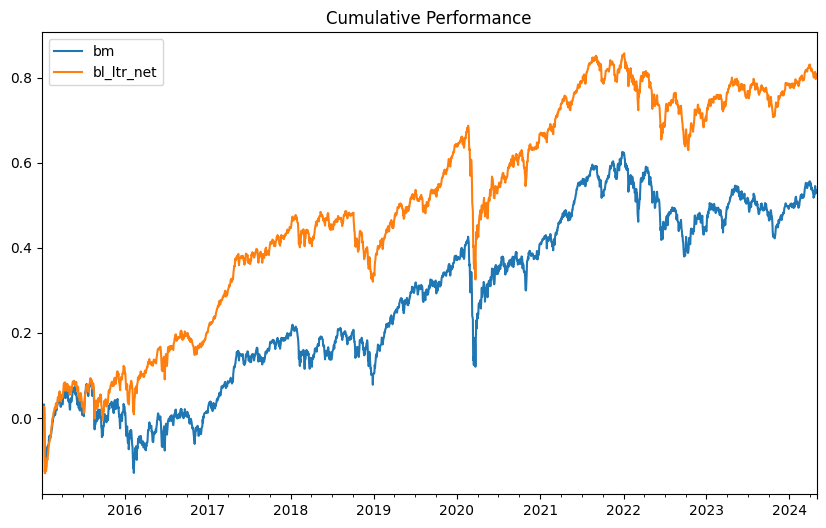

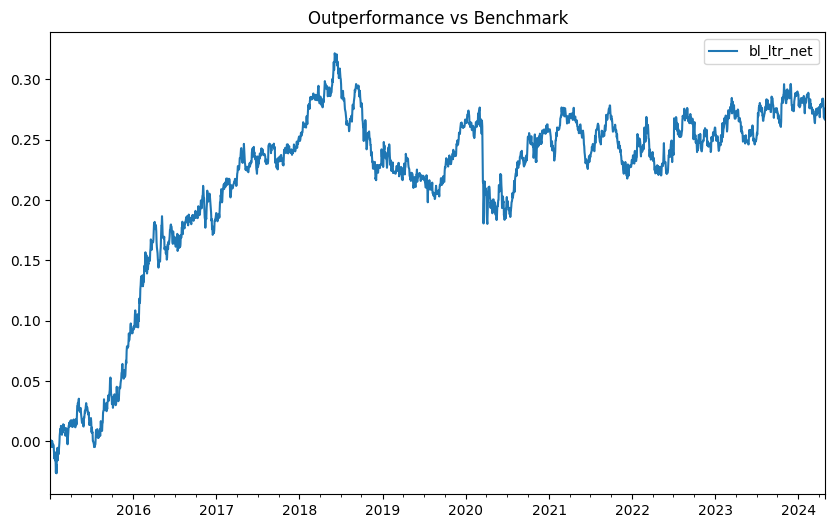

In [16]:
bt_bl_ltr = load_pickle(
    filename = 'backtest_bl_ltr.pickle',
    path = path,
)

#bt_sv_retrain_monthly = load_pickle(
#    filename = 'backtest_sv_retrain_monthly.pickle',
#    path = path,
#)

fixed_costs = 0
variable_costs = 0.002
return_series = bs.data.get_return_series()

strategy_dict = {
    'bl_ltr': bt_bl_ltr.strategy,
#    'sv_retrain_monthly': bt_sv_retrain_monthly.strategy,
}

sim_dict_gross = {
    f'{key}_gross': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=0,
    )
    for key, value in strategy_dict.items()
}
sim_dict_net = {
    f'{key}_net': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    )
    for key, value in strategy_dict.items()
}

# Flag: when True, scale the benchmark returns by the Net Exposure, to make the comparison fairer

# 1) fetch weights and calculate exposures
bm_weights_scale = False

# 1) fetch weights and calculate exposures
wts = bt_bl_ltr.strategy.get_weights_df()

# ensure the index is real datetime, not strings
wts.index    = pd.to_datetime(wts.index)

net_exposure = wts.sum(axis=1)
gross_exposure = wts.abs().sum(axis=1)
net_exposure.name   = "Net Exposure"
gross_exposure.name = "Gross Exposure"

# 2) build sim DataFrame with unscaled bm
sim = pd.concat({
    'bm': bs.data.bm_series,
    **sim_dict_net,
}, axis=1)

# 3) optionally scale bm in-place
if bm_weights_scale:
    # align net_exposure to sim’s index, fill any edge NaNs
    ne = net_exposure.reindex(sim.index).fillna(method='ffill').fillna(method='bfill')
    for col in sim.columns:
        sim[col] = sim[col] * ne

# 4) drop any remaining NaNs and plot
sim = sim.dropna()
#sim = sim.iloc[1:]  

cumulative_returns = np.log(1 + sim).cumsum()
cumulative_returns.plot(title='Cumulative Performance', figsize=(10, 6))

outperformance = cumulative_returns.subtract(cumulative_returns['bm'], axis=0)
outperformance.drop(columns=['bm'], errors='ignore').plot(
    title='Outperformance vs Benchmark', figsize=(10, 6)
)

The first graph illustrates the performance of the total return compared to the benchmark. As observed, both follow a similar trend after 2017. Notably, our strategy outperforms the benchmark between 2016 and 2019 and successfully maintains that advantage throughout the remaining period. The second graph further confirms this outperformance. 

One thing that is worth noting is that during the pandemic in 2020, the hisorical covariance matrix broke down, contributing to our large drawdown at the begininning of the decade. 

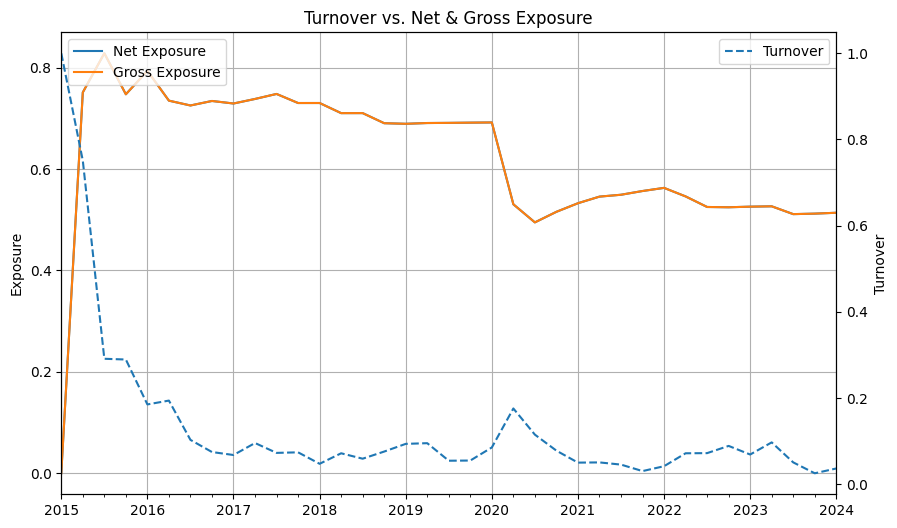

In [17]:
# existing turnover & weights
to_bl_ltr = bt_bl_ltr.strategy.turnover(return_series=return_series, rescale = False)
to_bl_ltr.index    = pd.to_datetime(to_bl_ltr.index)

# name turnover
to_bl_ltr.name = "Turnover"

# combine into one DataFrame
df = pd.concat([to_bl_ltr, net_exposure, gross_exposure], axis=1).dropna()

# plot Net & Gross Exposure on primary axis, Turnover on secondary
ax = df[["Net Exposure","Gross Exposure"]].plot(title="Turnover vs. Net & Gross Exposure", figsize=(10,6))
ax.set_ylabel("Exposure")
ax.grid(True)

ax2 = ax.twinx()
df["Turnover"].plot(ax=ax2, linestyle="--", label="Turnover")
ax2.set_ylabel("Turnover")
ax2.legend(loc="upper right")

# show legend for exposures
ax.legend(loc="upper left")

TODO

In [18]:
# Helper functions for performance metrics
def annual_return(series, periods_per_year=252):
    return (1 + series.mean()) ** periods_per_year - 1

def cumulative_returns(series):
    return (1 + series).prod() - 1

def annual_volatility(series, periods_per_year=252):
    return series.std() * np.sqrt(periods_per_year)

def sharpe_ratio(series, risk_free_rate=0, periods_per_year=252):
    excess_return = series - risk_free_rate / periods_per_year
    return excess_return.mean() / series.std() * np.sqrt(periods_per_year)

def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    return drawdown.min()


def tracking_error(series, benchmark):
    return (series - benchmark).std() * np.sqrt(252)

def downside_tracking_error(series, benchmark):
    active     = series - benchmark
    neg_active = active[active < 0]
    return np.sqrt(np.mean(neg_active**2)) * np.sqrt(252)

def information_ratio(series, benchmark):
    active = series - benchmark
    # annualized active return / annualized tracking error
    return (active.mean() * 252) / (active.std() * np.sqrt(252))


def capture_ratios(r_p: pd.Series, r_b: pd.Series) -> tuple[float,float]:
    """
    Calculate upside and downside capture of portfolio returns r_p vs. benchmark r_b.
    Returns (upside_capture, downside_capture).
    """
    up_ix   = r_b > 0
    down_ix = r_b < 0

    avg_p_up   = r_p[ up_ix].mean()
    avg_b_up   = r_b[ up_ix].mean()
    avg_p_down = r_p[down_ix].mean()
    avg_b_down = r_b[down_ix].mean()

    up_cap   = avg_p_up   / avg_b_up   if avg_b_up   else np.nan
    down_cap = avg_p_down / avg_b_down if avg_b_down else np.nan
    return up_cap, down_cap

# Helper function for hit ratio
def hit_ratio(series, benchmark):
    """
    Calculate the hit ratio: percentage of periods where the strategy outperforms the benchmark.
    """
    return (series > benchmark).mean()

# Compute individual performance metrics for each simulated strategy
annual_return_dict        = {}
cumulative_returns_dict   = {}
annual_volatility_dict    = {}
sharpe_ratio_dict         = {}
max_drawdown_dict         = {}
tracking_error_dict       = {}
downside_te_dict          = {}
information_ratio_dict    = {}
hit_ratio_dict            = {}  # New dictionary for hit ratio
up_capture_dict           = {}
down_capture_dict         = {}

for column in sim.columns:
    print(f'Performance metrics for {column}')
    # existing metrics
    annual_return_dict[column]      = annual_return(sim[column])
    cumulative_returns_dict[column] = cumulative_returns(sim[column])
    annual_volatility_dict[column]  = annual_volatility(sim[column])
    sharpe_ratio_dict[column]       = sharpe_ratio(sim[column])
    max_drawdown_dict[column]       = max_drawdown(sim[column])
    tracking_error_dict[column]     = tracking_error(sim[column], sim['bm'])
    downside_te_dict[column]        = downside_tracking_error(sim[column], sim['bm'])
    information_ratio_dict[column]  = information_ratio(sim[column], sim['bm'])
    hit_ratio_dict[column]          = hit_ratio(sim[column], sim['bm'])  # Calculate hit ratio
    
    # up/down capture (skip benchmark itself)
    if column != 'bm':
        up_cap, down_cap = capture_ratios(sim[column], sim['bm'])
        up_capture_dict[column]   = up_cap
        down_capture_dict[column] = down_cap

# Combine results into DataFrames
annual_returns     = pd.DataFrame(annual_return_dict,      index=['Annual Return'])
cumret             = pd.DataFrame(cumulative_returns_dict, index=['Cumulative Return'])
annual_volatility  = pd.DataFrame(annual_volatility_dict,  index=['Annual Volatility'])
sharpe             = pd.DataFrame(sharpe_ratio_dict,       index=['Sharpe Ratio'])
mdd                = pd.DataFrame(max_drawdown_dict,       index=['Max Drawdown'])
tracking_error     = pd.DataFrame(tracking_error_dict,     index=['Tracking Error'])
downside_te        = pd.DataFrame(downside_te_dict,        index=['Downside Tracking Error'])
info_ratio         = pd.DataFrame(information_ratio_dict,  index=['Information Ratio'])
hit_ratio_df       = pd.DataFrame(hit_ratio_dict,          index=['Hit Ratio'])  # New DataFrame for hit ratio
up_capture         = pd.DataFrame(up_capture_dict,         index=['Upside Capture'])
down_capture       = pd.DataFrame(down_capture_dict,       index=['Downside Capture'])

# Concatenate all metrics into a single DataFrame
performance_metrics = pd.concat([
    annual_returns,
    cumret,
    annual_volatility,
    sharpe,
    mdd,
    tracking_error,
    downside_te,
    info_ratio,
    hit_ratio_df,  # Add hit ratio here
    up_capture,
    down_capture
])

performance_metrics

Performance metrics for bm
Performance metrics for bl_ltr_net


C:\Users\nilsw\AppData\Local\Temp\ipykernel_20936\220375982.py:32: RuntimeWarning: invalid value encountered in scalar divide
  return (active.mean() * 252) / (active.std() * np.sqrt(252))


,bm,bl_ltr_net
Annual Return,0.067898,0.096450
Cumulative Return,0.701100,1.241378
Annual Volatility,0.145660,0.129850
Sharpe Ratio,0.451055,0.709239
Max Drawdown,-0.263289,-0.303189
Tracking Error,0.000000,0.065327
Downside Tracking Error,NaN,0.067194
Information Ratio,NaN,0.404023
Hit Ratio,0.000000,0.499383
Upside Capture,NaN,0.796392


TODO

## Further Results for Alternative Optimization Methods

In [ ]:
bs1 = BacktestService(
    data = data,
    optimization=opt1,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

bs2 = BacktestService(
    data = data,
    optimization=opt2,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

bs4 = BacktestService(
    data = data,
    optimization=opt4,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

bs5 = BacktestService(
    data = data,
    optimization=opt5,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
    )

In [ ]:
#path = "C:/Users/angus/OneDrive/Desktop/QPMwP/Investment_Strategy/BACKTESTS/"  # <change this to your path where you want to store the backtest>
path = "C:/Users/nilsw/QPM/qpmwp-course/BACKTESTS/"

bt_bl_ltr1 = Backtest()
bt_bl_ltr1.run(bs=bs)
filename = 'backtest_bl_ltr1.pickle' 
bt_bl_ltr1.save(
     path = path, 
     filename = filename 
)

bt_bl_ltr2 = Backtest()
bt_bl_ltr2.run(bs=bs)
filename = 'backtest_bl_ltr2.pickle' 
bt_bl_ltr2.save(
     path = path, 
     filename = filename 
)

bt_bl_ltr4 = Backtest()
bt_bl_ltr4.run(bs=bs)
filename = 'backtest_bl_ltr4.pickle' 
bt_bl_ltr4.save(
     path = path, 
     filename = filename 
)

bt_bl_ltr5 = Backtest()
bt_bl_ltr5.run(bs=bs)
filename = 'backtest_bl_ltr5.pickle'
bt_bl_ltr5.save(
     path = path, 
     filename = filename 
)

In [ ]:
backtest_files = [
    ('backtest_bl_ltr.pickle', 'MeanVariance'),
    ('backtest_bl_ltr1.pickle', 'BlackLitterman'),
    ('backtest_bl_ltr2.pickle', 'ScoreVariance'),
    ('backtest_bl_ltr4.pickle', 'MaxSharpe'),
    ('backtest_bl_ltr5.pickle', 'BlackLittermanMS'),
]

fixed_costs = 0
variable_costs = 0.002
return_series = bs.data.get_return_series()

sim_dict_net = {}

for filename, label in backtest_files:
    bt = load_pickle(filename=filename, path=path)
    sim = pd.concat({
        'bm': bs.data.bm_series,
        label: bt.strategy.simulate(
            return_series=return_series,
            fc=fixed_costs,
            vc=variable_costs,
        ),
    }, axis=1).dropna()

# Combine all strategies and benchmark into a single DataFrame
sim = pd.concat(
    {'bm': bs.data.bm_series, **sim_dict_net},
    axis=1
).dropna()

cumulative_returns = np.log(1 + sim).cumsum()
cumulative_returns.plot(title=f'Cumulative Performance: {label}', figsize=(10, 6))

# Appendix A - Backtesting

## A.1 bibfn_equal_weights

```python
def bibfn_equal_weights(bs: 'BacktestService', rebdate: str, **kwargs) -> None:

    # Selection
    ids = bs.selection.selected

    # Data - market capitalization
    mcap = bs.data.market_data['mktcap']

    # Get last available values for current rebdate
    mcap = mcap[mcap.index.get_level_values('date') <= rebdate].groupby(
        level = 'id'
    ).last()

    # Remove duplicates
    mcap = mcap[~mcap.index.duplicated(keep=False)].loc[ids]
    
    # Attach cap-weights to the optimization data object
    bs.optimization_data['cap_weights'] = (0*mcap+1)/ len(mcap)

    return None
```

---

## A.2 bibfn_sector_exposure_constraints

```python

def bibfn_sector_exposure_constraints(
    bs: 'BacktestService',
    rebdate: str,
    limits: dict = None,
    default_limit: float = 0.2,
    sector_field: str = 'sector', **kwargs
) -> None:
    """
    Backtest item builder that adds linear constraints on sector weights:
    sum of weights for each sector <= specified limit.

    Args:
        bs: BacktestService
        rebdate: rebalance date
        limits: dict mapping sector name to maximum weight (e.g. {'Tech':0.2, 'Health':0.15});
                if None, uses kwargs defaults or a uniform limit of 0.2
        sector_field: name of sector column in bs.data.market_data
    """
    # Load sector data
    sd = bs.data.market_data[sector_field]
    # get last available sector per id up to rebalance date
    sd = sd[sd.index.get_level_values('date') <= rebdate]
    last_sector = sd.groupby(level='id').last()

    # Determine unique sectors
    sectors = last_sector.unique()

    # Default uniform limit if none provided
    if limits is None:
        # uniform 20% per sector
        limits = {s: default_limit for s in sectors}

    # Build G matrix: one row per sector
    ids = bs.optimization.constraints.ids
    # Initialize DataFrame for G and RHS
    G_rows = []
    sense = []
    rhs = []
    names = []
    for sector, lim in limits.items():
        # indicator 1 for ids in this sector, else 0
        mask = (last_sector.reindex(ids).fillna('') == sector).astype(int)
        # skip if no ids in this sector
        if mask.sum() == 0:
            continue
        G_rows.append(mask.values)
        sense.append('<=')
        rhs.append(lim)
        names.append(f"sect_{sector}")

    # create DataFrame G with index names and columns ids
    G = pd.DataFrame(G_rows, index=names, columns=ids)
    rhs = pd.Series(rhs, index=names)
    # Add linear constraints
    bs.optimization.constraints.add_linear(G=G, sense=sense, rhs=rhs)
    return None
```



# Appendix B - Optimization

## B.1 MaxSharpe

```python
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 turnover_penalty: Optional[float] = None,
                 risk_aversion: float = 1.0,
                 iterations: int = 10, 
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.params['turnover_penalty'] = turnover_penalty
        self.params['risk_aversion'] = risk_aversion
        self.iterations = iterations

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.data = optimization_data
        X = optimization_data['return_series']
        self.cov = self.covariance.estimate(X=X, inplace=False)
        self.mu  = self.expected_return.estimate(X=X, inplace=False)
        self.objective = Objective(
            q = -1.0 * self.mu,
            P = 2.0 * self.cov,
        )
        self.base_P = copy.deepcopy(2.0 * self.cov)

    def solve(self) -> None:
        parent_solve = super(MaxSharpe, self).solve

        def _neg_sharpe(lam: float) -> float:
            # scale P and re-solve
            self.params['risk_aversion'] = lam
            self.objective.coefficients["P"] = self.base_P * lam
            parent_solve()
            w = np.array(list(self.results["weights"].values()))
            sr = (self.mu @ w) / np.sqrt(w @ self.cov @ w)
            return -sr

        # one-line search over [1e-2,1e2]
        res = minimize_scalar(
            _neg_sharpe,
            bounds=(1e-2, 1e2),
            method="bounded",
            options={"maxiter": self.iterations, "xatol": 1e-3}
        )

        # unpack results
        best_lambda = res.x
        best_sharpe = -res.fun
        # re-solve once at the optimum to populate weights
        self.objective.P = self.base_P * best_lambda
        parent_solve()
        print('best_lambda:', best_lambda)
        self.results = {
            "weights":       self.results["weights"],
            "best_sharpe":   best_sharpe,
            "risk_aversion": best_lambda,
            "status":        True,
        }
        return None
```
---

## B.2 BlackLittermanMS

```python
class BlackLittermanMS(Optimization):

    def __init__(self,
                 fields: list[str],
                 covariance: Optional[Covariance] = None,
                 risk_aversion: float = 1,
                 tau_psi: float = 1,
                 tau_omega: float = 1,
                 view_method: str = 'absolute',
                 scalefactor: int = 1,
                 iterations: int = 5,
                 **kwargs) -> None:
        super().__init__(
            fields=fields,
            risk_aversion=risk_aversion,
            tau_psi=tau_psi,
            tau_omega=tau_omega,
            view_method=view_method,
            scalefactor=scalefactor,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.iterations = iterations
    def set_objective(self, optimization_data: OptimizationData) -> None:
        '''
        Sets the objective function for the optimization problem.
        
        Parameters:
        training_data: Training data which must contain 
            return series (to compute the covariances) and scores.
        '''
        self.data = optimization_data
        # Retrieve configuration parameters from the params attribute
        fields = self.params.get('fields')
        risk_aversion = self.params.get('risk_aversion')
        tau_psi = self.params.get('tau_psi')
        tau_omega = self.params.get('tau_omega')
        view_method = self.params.get('view_method')
        scalefactor = self.params.get('scalefactor')

        # Calculate the covariance matrix
        self.covariance.estimate(
            X=optimization_data['return_series'],
            inplace=True,
        )

        # Extract benchmark weights
        cap_weights = optimization_data['cap_weights']

        # # Alternatively, calculate minimum tracking error portfolio
        # optim = LeastSquares(
        #     constraints = self.constraints,
        #     solver_name = self.params.get('solver_name'),
        # )
        # optim.set_objective(optimization_data=optimization_data)
        # optim.solve()
        # cap_weights = pd.Series(optim.results['weights'])

        # Implied expected return of benchmark
        mu_implied = risk_aversion * self.covariance.matrix @ cap_weights

        # Extract scores
        scores = optimization_data['scores'][fields]

        # Construct the views
        P_tmp = {}
        q_tmp = {}
        for col in scores.columns:
            P_tmp[col], q_tmp[col] = generate_views_from_scores(
                scores=scores[col],
                mu_implied=mu_implied,
                method=view_method,
                scalefactor=scalefactor,
            )

        P = pd.concat(P_tmp, axis=0)
        q = pd.concat(q_tmp, axis=0)

        # Define the uncertainty of the views
        Omega = pd.DataFrame(
            np.diag([tau_omega] * len(q)),
            index=q.index,
            columns=q.index
        )
        Psi = self.covariance.matrix * tau_psi

        # Compute the posterior expected return vector
        mu_posterior = bl_posterior_mean(
            mu_prior=mu_implied,
            P=P,
            q=q,
            Psi=Psi,
            Omega=Omega,
        )
        
        self.mu = copy.deepcopy(mu_posterior)
        self.cov = copy.deepcopy(self.covariance.matrix)

        self.objective = Objective(
            q = mu_posterior * (-1),
            P = self.covariance.matrix * risk_aversion * 2,
            mu_implied = mu_implied,
            mu_posterior = mu_posterior,
        )


    def solve(self) -> None:
        parent_solve = super(BlackLittermanMS, self).solve

        def _neg_sharpe(lam: float) -> float:
            # scale P and re-solve
            self.params['risk_aversion'] = lam
            self.set_objective(optimization_data=self.data)
            parent_solve()
            w = np.array(list(self.results["weights"].values()))
            sr = (self.mu @ w) / np.sqrt(w @ self.cov @ w)
            return -sr

        # one-line search over [1e-2,1e2]
        res = minimize_scalar(
            _neg_sharpe,
            bounds=(1e-2, 1e2),
            method="bounded",
            options={"maxiter": self.iterations, "xatol": 1e-3}
        )

        # unpack results
        best_lambda = res.x
        best_sharpe = -res.fun
        # re-solve once at the optimum to populate weights
        self.params['risk_aversion'] = best_lambda
        self.set_objective(optimization_data=self.data)
        parent_solve()
        print('best_lambda:', best_lambda)
        self.results = {
            "weights":       self.results["weights"],
            "best_sharpe":   best_sharpe,
            "risk_aversion": best_lambda,
            "status":        True,
        }
        return None
```

# Appendix C - Covariance

## C.1 - _impute
```python
from sklearn.impute import SimpleImputer

def _impute(X, strategy='mean'):
    """Return numpy array with NaNs imputed by column mean/median."""
    imputer = SimpleImputer(strategy=strategy)               # :contentReference[oaicite:0]{index=0}
    return imputer.fit_transform(X)
```
---

## C.2 - cov_ledoit
```python
def cov_ledoit(X, strategy='mean'):
    arr = X.values if isinstance(X, pd.DataFrame) else X
    arr_filled = _impute(arr, strategy=strategy)
    lw = LedoitWolf()
    lw.fit(arr_filled)
    cov = lw.covariance_
    if isinstance(X, pd.DataFrame):
        return pd.DataFrame(cov, index=X.columns, columns=X.columns)
    return cov
```
---

## C.3 - cov_mcd
```python
def cov_mcd(X, strategy='mean'):
    arr = X.values if isinstance(X, pd.DataFrame) else X
    arr_filled = _impute(arr, strategy=strategy)
    mcd = MinCovDet()
    mcd.fit(arr_filled)
    cov = mcd.covariance_
    if isinstance(X, pd.DataFrame):
        return pd.DataFrame(cov, index=X.columns, columns=X.columns)
    return cov
```
---

## C.4 cov_ewma_ledoit

```python
def cov_ewma_ledoit(
    X: pd.DataFrame,
    span: int = 252,
    impute_strategy: str = 'mean'
) -> pd.DataFrame:

    arr = X.values
    if impute_strategy == 'mean':
        col_means = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_means, inds[1])
    elif impute_strategy == 'zero':
        arr = np.nan_to_num(arr, 0.0)
    
    T, p = arr.shape
    λ = (span - 1) / span
    w = λ ** np.arange(T-1, -1, -1)
    w = w / w.sum()
    mean_w = w @ arr
    A = arr - mean_w  
    S_ewma = (A.T * w) @ A

    Xw = A * np.sqrt(w)[:, None]
    lw = LedoitWolf().fit(Xw)
    δ = lw.shrinkage_
    mu = np.trace(S_ewma) / p

    Σ_shrunk = (1 - δ) * S_ewma + δ * mu * np.eye(p)

    return pd.DataFrame(Σ_shrunk, index=X.columns, columns=X.columns)

```
---


## C.5 - cov_nonlinear_shrink
```python
def cov_nonlinear_shrink(
    X: pd.DataFrame,
    bandwidth: float = None,
    impute_strategy: str = 'mean'
) -> pd.DataFrame:

    arr = X.values.copy()
    if impute_strategy == 'mean':
        col_means = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_means, inds[1])
    else:
        arr = np.nan_to_num(arr, 0.0)


    S = np.cov(arr, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(S)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

    kde = gaussian_kde(eigvals, bw_method=bandwidth)
    grid = np.linspace(eigvals.min(), eigvals.max(), 200)
    pdf_grid = kde(grid)
    λ_shrunk = np.empty_like(eigvals)
    for i, λ in enumerate(eigvals):
        w = np.exp(-0.5 * ((grid - λ) / kde.factor)**2)
        λ_shrunk[i] = (w * grid * pdf_grid).sum() / (w * pdf_grid).sum()

    λ_shrunk = np.clip(λ_shrunk, 1e-8, None)

    Σ_nl = (eigvecs * λ_shrunk) @ eigvecs.T

    return pd.DataFrame(Σ_nl, index=X.columns, columns=X.columns)
```